# Быстрое возведение в степень(mul sqr)

$x^{17} = (((x^2)^2)^2)^2 * x$, `17 = 0b10001`

$x^{13} = ((x^2 * x)^2)^2 * x$, `13 = 0b1101`


С другой стороны

$x^{17} = x * (x^8)^2$

In [3]:
p = random_prime(2**256)
a = randint(1, p - 1)
e = randint(1, p - 1)
e

83026608548738245453917705950273588408898877393849284746955644504860381267579

In [5]:
def fast_pow(x, n):
    res = x
    for i in bin(n)[2:][1:]:
        res = res^2
        if i == '1':
            res *= x
    return res        

def rec_fast_pow(x, n):
    if n == 1:
        return x
    if n < 0:
        return rec_fast_pow(1/x, -n)

    if n & 1 == 0:
        return rec_fast_pow(x, n//2)^2
    else:
        return x * rec_fast_pow(x, n//2)^2

In [6]:
p = random_prime(2**256)
G = GF(p)
for i in range(10000):
    a = G.random_element()
    e = randint(1, p-1)
    assert a^e == fast_pow(a, e)
    assert a^e == rec_fast_pow(a, e)

# DLP

$g^x = h, x - ?$

# BSGS

$n = ord(g)$

$m \approx \sqrt{n}$

$Gs = [e, g, g^2, g^3, ..., g^m]$

$Hs = [h * g^{-m}, h * g^{-2m},..., h * g^{-m^2}]$

$g^i = h * g^{-j m} \implies g^{i + j m} = h \implies x = i + j m \pmod{ord(g)}$

In [8]:
def babystep_giantstep(g, h):
    n = g.multiplicative_order()
    m = 1 + ceil(sqrt(n))

    lg = {}
    gi = 1
    for i in range(m):
        lg[gi] = i
        gi *= g

    invg = g ** (-m)
    hi = h
    for j in range(m + 1):
        if hi in lg:
            i = lg[hi]
            return i + j * m
        hi *= invg

In [9]:
p = random_prime(2**40)
G = GF(p)
g = G.random_element()
x = randint(1, p - 1)
h = g^x
babystep_giantstep(g, h)

157738295944

In [10]:
x

157738295944

# Парадокс дней рождений

Допустим у вас есть набор из $n$ элементов. Какова вероятность того, что выбирав наугад $m$ элементов, хотя бы два из них будут одинаковые?

Пусть $P(n, m)$ - Вероятность того, что хотя бы два элемента совпадают, а $P_1(n, m)$ - не совпадает ни один элемент. $P(n, m) = 1 - P_1(n, m)$

$P_1(n, m) = (1 - \frac{1}{n})(1 - \frac{2}{n})(1-\frac{3}{n})...(1-\frac{m-1}{n})$

Из МатАна мы знаем, что $1 - x \approx e^{-x}, x \to 0$

Тогда интуитивно $P_1(n, m) \approx e^{-\frac{1}{n}} * ... * e^{-\frac{m}{n}} = e^{-\frac{1 + 2 + ... + m-1}{n}}$

$P_1(n, m) \approx e^{-\frac{m^2}{n}} = e^{-\lambda}$

$P(n, m) = 1 - e^{-\lambda}$

Еcли возьмем $\lambda = 3$, то получим $m = \sqrt{3 * n}$

In [19]:
1 - exp(-3.0)

0.950212931632136

In [26]:
n = 365
m = 70
(1 - prod(1 - j / n for j in range(m))).n(), 1 - exp(-70^2 / 365.)

(0.999159575965157, 0.999998521758769)

gs = $g^i$

hs = $h * g^j$

In [27]:
def birthday_algo(g, h):
    n = g.multiplicative_order()
    m = floor(3 * sqrt(n))

    gs = {}
    hs = {}

    for i in range(m):
        a = randint(0, n)
        ga = pow(g, a)
        gs[ga] = a

        if ga in hs:
            return a - hs[ga]  # not modded

        a = randint(0, n)
        ha = pow(g, a) * h
        hs[ha] = a

        if ha in gs:
            return gs[ha] - a

In [28]:
p = random_prime(2**40)
G = GF(p)
g = G.random_element()
x = randint(1, p - 1)
h = g^x
birthday_algo(g, h)

-633645078361

In [30]:
pow(g, -633645078361, p), h

(623632244814, 623632244814)

# Поллард

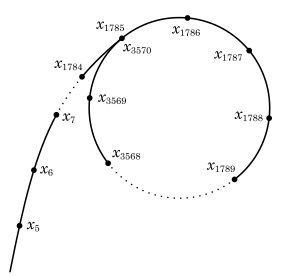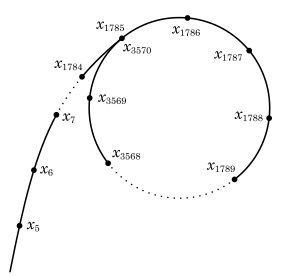


$x_i = f(x_{i - 1})$

$y_i = f(f(y_{i - 1}))$



$x_i = g^{a_i} * h^{b_i}$

$y_i = g^{c_i} * h^{d_i}$

$g^{a_i - c_i} = h^{b_i - d_i}$

$a_i - c_i = x * (b_i - d_i) \pmod{ord(g)}$


In [41]:
def getPowers(a, x, g, h, p, k=1):
    ax, bx = a

    N = p
    if int(x) < N // 3:
        ax += 1
        x *= g
    elif int(x) >= N // 3 and int(x) < 2 * N // 3:
        ax *= 2
        bx *= 2
        x = x**2
    else:
        bx += 1
        x *= h

    return (ax, bx), x


def pollard_rho(g, h, p, ord):
    N = ord
    Pm = Zmod(N)

    ex = (Pm(0), Pm(0)) # ex_0 = power(g), ex_1 = h power(g)
    ey = (Pm(0), Pm(0)) # ey_0 = power(g), ey_1 = h power(g)

    G = GF(p)
    x, y = G(1), G(1)
    while True:
        ex, x = getPowers(ex, x, g, h, p)

        ey, y = getPowers(ey, y, g, h, p)
        ey, y = getPowers(ey, y, g, h, p)

        if x == y:
            break

    u = int(ex[0] - ey[0])
    v = int(ey[1] - ex[1])
    d = gcd(v, N)
    assert u % d == 0

    u //= d
    N //= d
    v //= d

    res = (pow(v, -1, N) * u) % N
    dlp = []
    for k in range(d):
        dlp.append(res + k * N)

    return dlp

In [42]:
p = random_prime(2**40)
G = GF(p)
g = G.random_element()
x = randint(1, p - 1)
h = g^x
pollard_rho(g, h, p, g.multiplicative_order())

[1160803442, 61056682715, 120952561988]

(13975830685, 8497546240)

# Полиг-Хеллман

$ord(g) = p_1^{e_1} * p_2^{e_2} * ...$

$g_1 = g^{\frac{ord(g)}{p_1^{e_1}}}$

$ord(g_1) = p_1^{e_1}$

$g_1^x = h_1$

$x \pmod{p_1^{e_1}} = x_{(1, 1)} + x_{(1, 2)} * p + x_{(1, 3)} * p^2 + ...$

$h_1 = g_1^{x_{(1, 1)} + x_{(1, 2)} * p + x_{(1, 3)} * p^2 + ...}$

$g_{(1, 1)} = g_1^{p_1^{e_1 - 1}}, ord(g_{(1, 1)}) = p_1$ - Находим как-нибудь $x_{(1, 1)}$. 


$h_1 * g_1^{-x_{(1, 1)}} = (g_1^{p_1})^{x_{(1, 2)} + ..}$

$x_{(1, 1)} * p_1^{e_1 -1} + p_1^{e_1} * (x_{(1, 2)} + ... )$

$g_{(1, 1)} = g_1^{x_{(1, 1)} p_1^{e_1 -1}} * g_1^{p_1^{e_1} * (x_{(1, 2)} + ... }$

$ord(g_{(1, 1)}) = p_1$

In [58]:
p = 4216863803
G = GF(p)
g = G(2)
x = randint(1, p - 1)
h = g^x
factor(p - 1)

2 * 44201 * 47701

In [67]:
p1, p2, p3 = 2, 44201, 47701

g1 = g^((p - 1) // p1)
h1 = h^((p - 1) // p1)
# x mod(2) = 1

g2 = g^((p - 1) // p2)
h2 = h^((p - 1) // p2)
babystep_giantstep(g2, h2)
# x mod(44201) = 42152


g3 = g^((p - 1) // p3)
h3 = h^((p - 1) // p3)
babystep_giantstep(g3, h3)
# x mod(47701) = 18595
crt([1, 42152, 18595], [p1, p2, p3])

4122625221

In [69]:
while True:
    q = random_prime(2**255)
    p = 1 + 2 * q
    if is_prime(p):
        break

In [70]:
p, factor(p - 1)

(95894242212572827485371794337469066798087882200658739962461694388629020230079,
 2 * 47947121106286413742685897168734533399043941100329369981230847194314510115039)

In [68]:
g^4122625221, h

(1018983300, 1018983300)

In [72]:
p = 311414346572387
factor(p - 1)

2 * 52313^2 * 56897

In [75]:
G = GF(p)
g = G(2)
x = randint(1, p - 1)
h = g^x

In [87]:
q = 52313
g_1 = g^((p - 1) // (2 * 56897))
h_1 = h^((p - 1) // (2 * 56897))

g_2 = g_1^q
h_2 = h_1^q

x_0 = babystep_giantstep(g_2, h_2)

g_3 = g_1^p
h_3 = h_1 * g_1^(-x_0)

4866

In [47]:
G = GF(p)
g = G.multiplicative_generator()

In [50]:
g^(g.multiplicative_order() // 52313)

42110834038632

In [51]:
G(42110834038632).multiplicative_order()

52313

In [53]:
p.bit_length()

49

In [71]:
p = 89330422448946086031679413136848658460951672937510146565627338919634303319603
factor(p - 1)

2 * 17137 * 31337 * 137321 * 139609 * 149771 * 157649 * 157721 * 159623 * 164183 * 169501 * 170473 * 186871 * 188687 * 203669 * 214219

In [92]:
discrete_log(h, g), x

(66122291902745, 66122291902745)

In [93]:
h.log(g)

66122291902745